## Code for Apstat Lab 2/12/24 - Konrad Skovmand Olsen

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from scipy import stats
from scipy import special
from scipy.special import erfc                         # Error function, to get integral of Gaussian
from scipy.signal import find_peaks
import random as r


## Data

In [209]:
a = np.deg2rad(90-10)
Length_laser = np.array([22.286,22.288,22.276])

print(np.sin(a)*Length_laser.mean())

21.944799429622034


In [172]:
#Pendulum length d
Length_laser = [22.286,22.288,22.276]

Laser_err = 0.00005#m
Length_laser_mean = np.mean(Length_laser)-0.18-0.035
Length_Tape = [22.18] #m
massmiddle_tape = Length_Tape[0]-0.18-0.5*0.035
Length_err = 0.0005#m
Ground_Pendulum = 0.18#m
length_of_pendulum= 0.035#m  
Ground_Pendulumerr = 0.001#m
error_pendul_laser = np.sqrt(Laser_err**2+Length_err**2+3/4*Ground_Pendulumerr**2) #Roughly just Length_err
error_tape_total = np.sqrt(Length_err**2+3/4*Ground_Pendulumerr**2)

# Pendulum period
Period_k = [] #Konrad
Period_m = [] #Magnus
Period_t = [] #Thomas

#Pendulum timing precisions (Uncertainties)
sigma_kon = [] #Konrad
sigma_mag = [] #Magnus
sigma_tho = [] #Thomas

#Rolling Ball timing and gate positions
Rolling_time = []
Rolling_Positions = []
Gate_diff_K = [20.75,37.95,55.1,71.5,89.45] #cm
Gate_diff_T = [20.75, 37.35, 55.05, 71.50,89.45]
Gate_diff_M = [20.75, 37.40, 55.05, 71.50, 89.45]

Lengt_err = 0.05
D_rail = [5.9,5.4,6] #mm, K, T, M
D_railerr = [0.1,0.1,0.1] #mm

#Rolling ball acceleratiwon
Rolling_acc = [] # Found from above with quadratic fit 

#Rolling ball diameter and rail distance
Ball_diameter_k = [14.9,14.8,14.8] #mm
Ball_diameterer = 0.1 #mm
#Rolling ball incline angle
Angle_trig = []
Angle_gon = []
sigma_trig = []
sigma_gon = []

#Rolling ball table angle
Table_angle = []
Table_uncertainty = []


## Functions

In [173]:
def linfunc(x,a,b): #For period
    return a*x+b

def g_pendul(L,T): #Tyngdeacceleration for pendul
    return L*(2*np.pi/T)**2

def g_error(L,T,sigma_L,sigma_T): #Ophobning for pendul
    return np.sqrt(((2*np.pi/T)**2*sigma_L)**2+((8*L*np.pi**2*(1/T)**3)*sigma_T)**2)

def gauss_pdf(x, mu, sigma,N) :
    """Gaussian"""
    return N / np.sqrt(2*np.pi* sigma**2) * np.exp( -1* (x-mu)**2 / (2*sigma**2))

def fit_pdf_llhfit(x, N, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return N * gauss_pdf(x,mu,sigma,N=Ngauss) 

## Blinding + data stuff

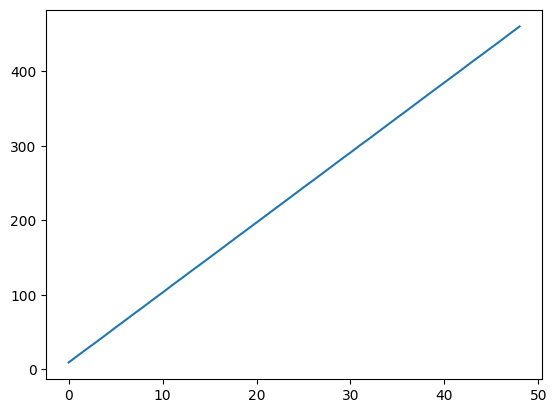

In [174]:
Pendulum_data = 'pendulum_swings.csv'
pendulum_values = 2*(np.loadtxt(Pendulum_data,delimiter=';')/10000).T
Blind = False
r = np.random             # Random generator
r.seed(42)
if Blind:
    pendulum_values+=r.normal(0,1,len(pendulum_values[0]))
time_space=np.arange(0,49,1)
plt.plot(time_space,pendulum_values[0])

For the measurements with the laser


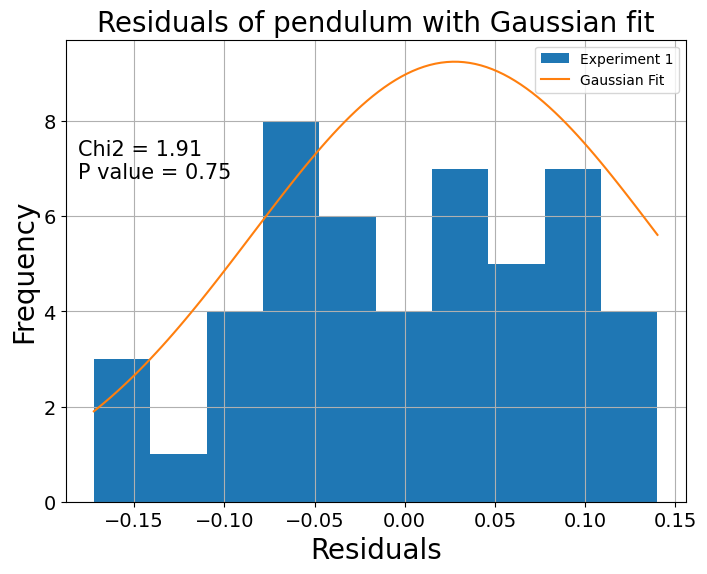

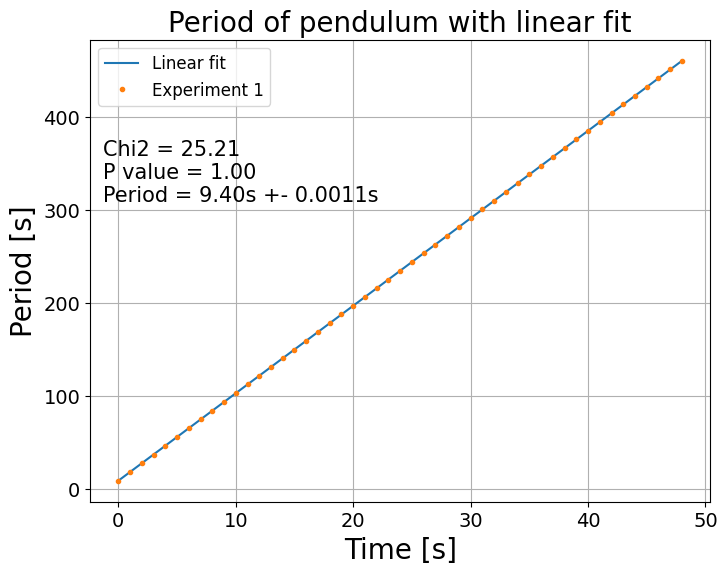

9.3955634693865 period +- 0.0011355655485075764


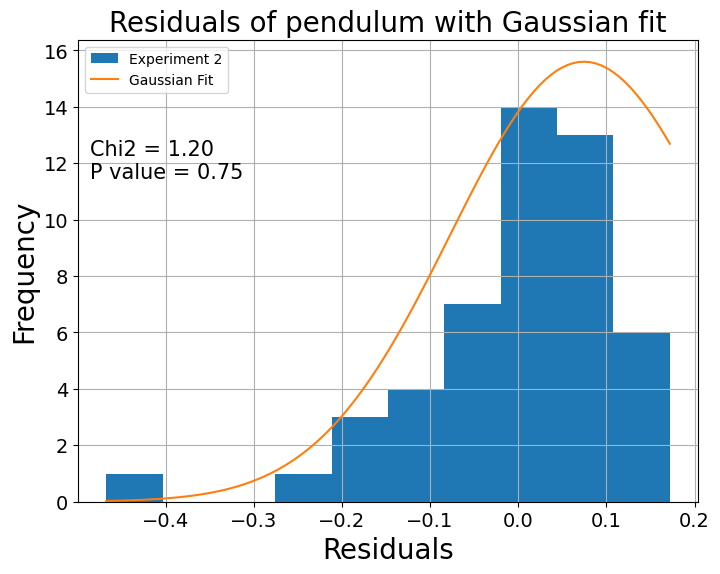

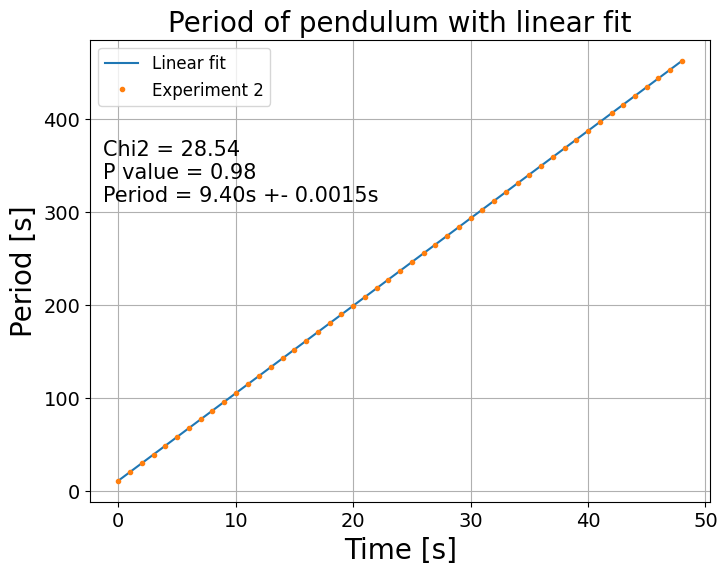

9.398358959183573 period +- 0.0015321201390646475


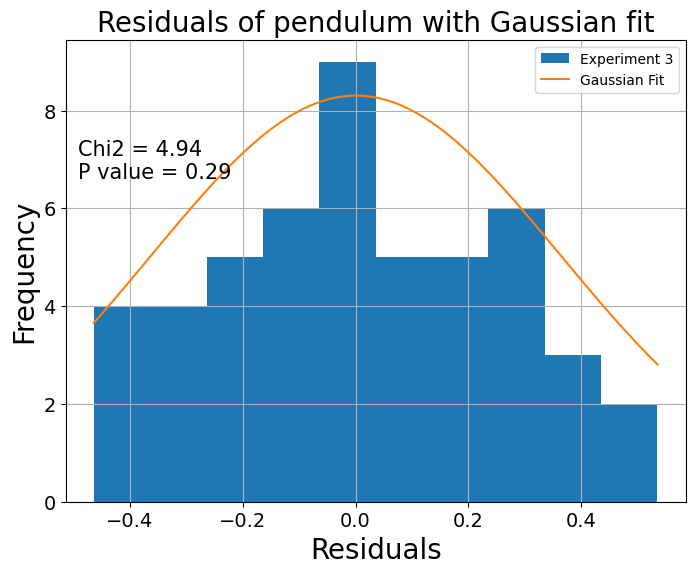

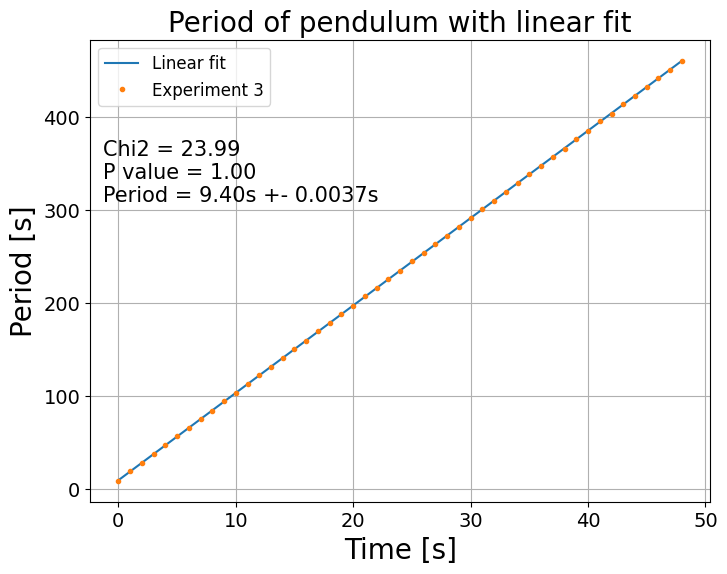

9.3982231632659 period +- 0.0036689504780015748
The measured values of the gravitational acceleration were 9.869+-0.0024 m/s^2
The measured values of the gravitational acceleration were 9.863+-0.0032 m/s^2
The measured values of the gravitational acceleration were 9.864+-0.0077 m/s^2
Weighted average using only the first three (good) files
9.867133168927555,+-, 0.0019

For the measurement with tape


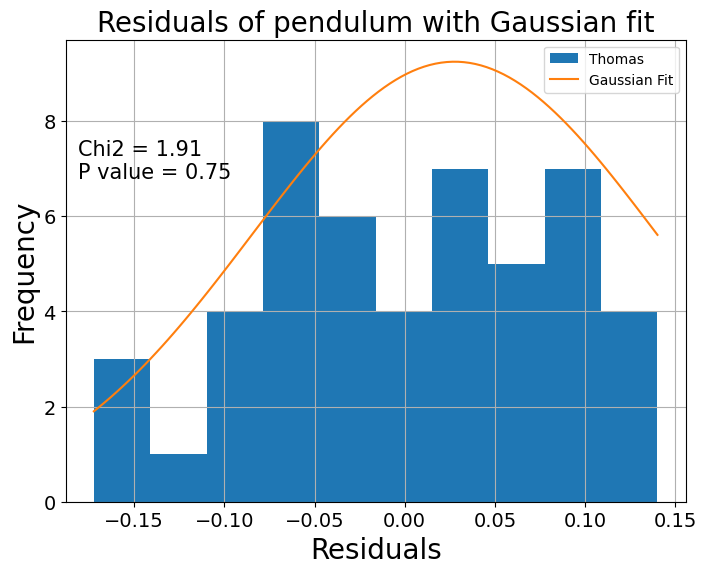

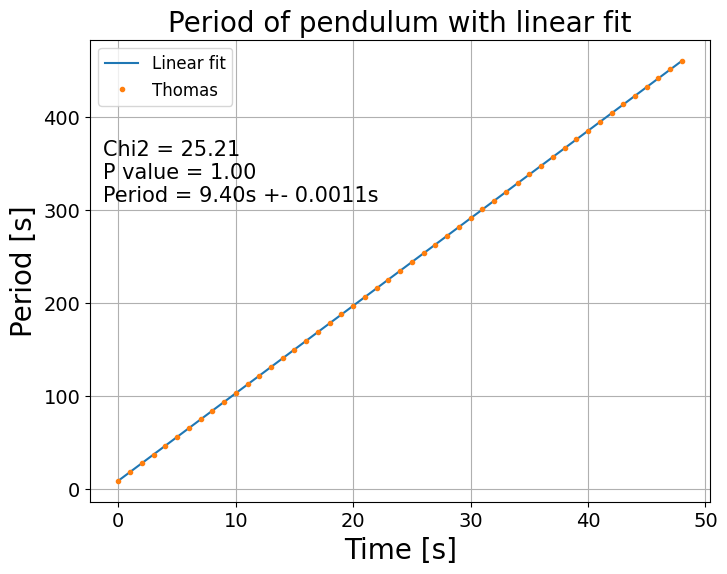

9.3955634693865 period +- 0.0011355655485075764


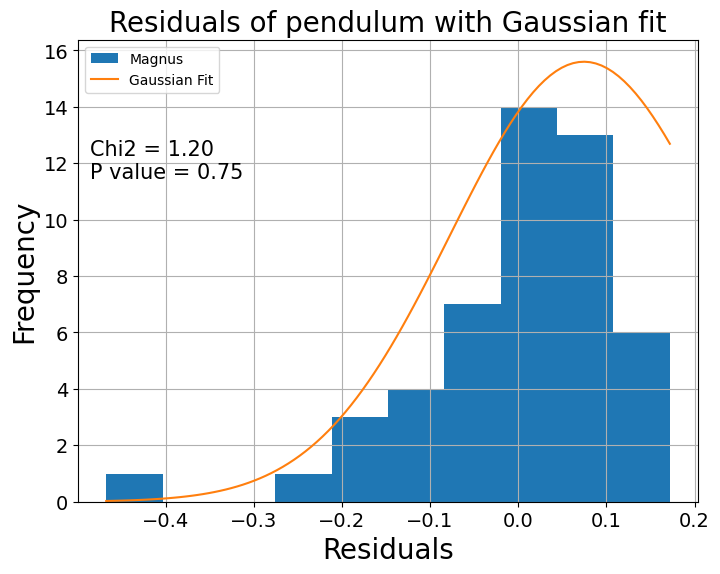

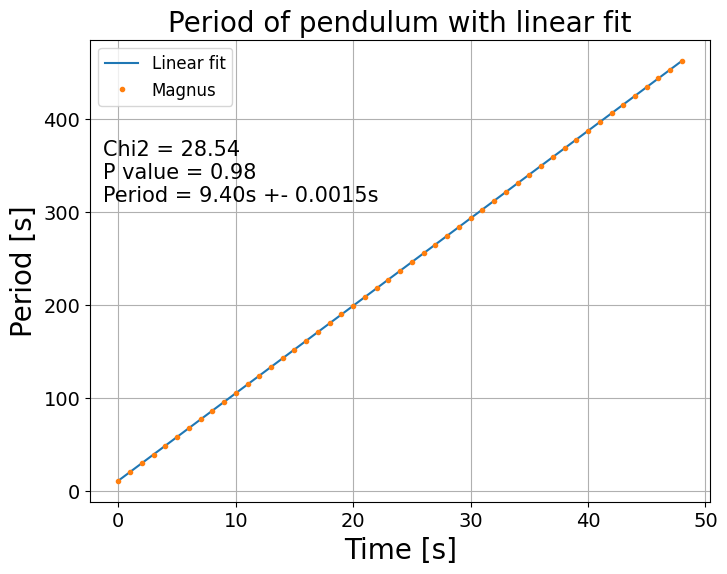

9.398358959183573 period +- 0.0015321201390646475


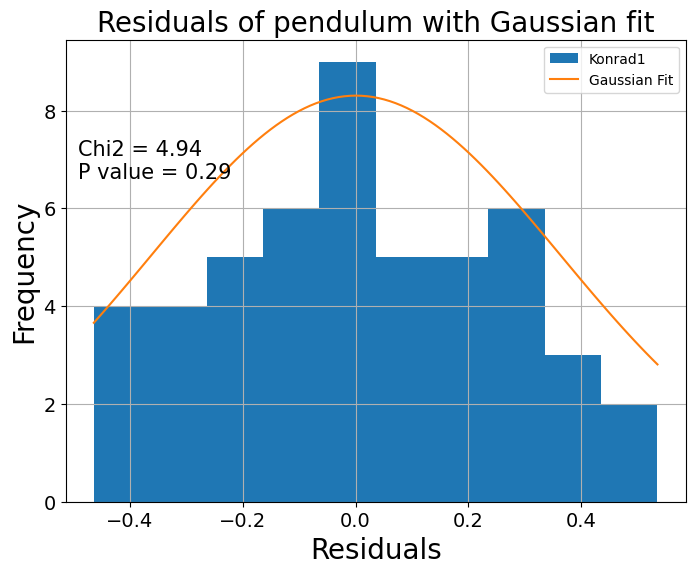

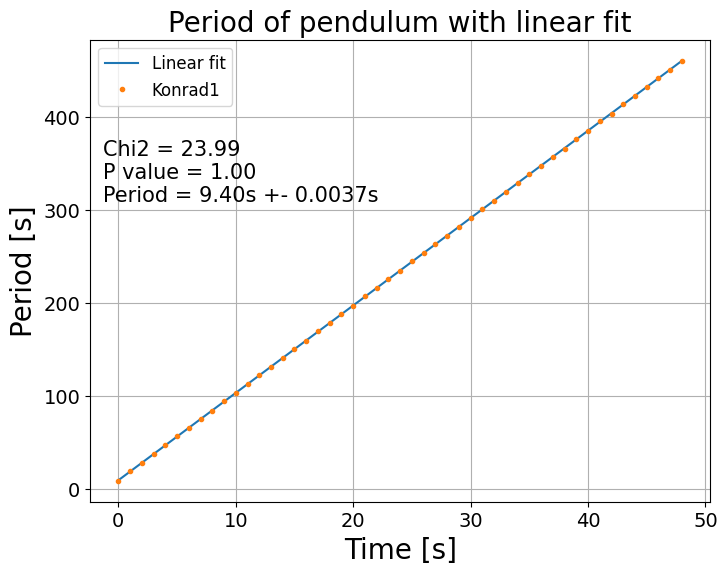

9.3982231632659 period +- 0.0036689504780015748
The measured values of the gravitational acceleration were 9.831+-0.0024 m/s^2
The measured values of the gravitational acceleration were 9.825+-0.0032 m/s^2
The measured values of the gravitational acceleration were 9.825+-0.0077 m/s^2
Weighted average using only the first three (good) files
9.828755495047451,+-, 0.0019


In [183]:
def errorfunc(i, labels):
    sy = 1
    time_space=np.arange(0,49,1)
    test = cost.LeastSquares(time_space,i,sy,linfunc) 
    mfit = Minuit(test, a=2, b=1)
    mfit.migrad()
    fitparams = mfit.values
    a,b = fitparams['a'],fitparams['b']
    yfit = linfunc(time_space,a,b)

    count, bins = np.histogram((i-yfit), bins=int(np.sqrt(len(i))))
    mask = count > 0
    count = count[mask]
    bincenters = 0.5*(bins[1:]+bins[:-1])[mask] 
    gaussfit = cost.LeastSquares(bincenters, count, np.sqrt(count), model=gauss_pdf)
    count = count[count>0]
    binwidth = bins[1]-bins[0]
    m2 = Minuit(gaussfit, mu=0, sigma=20,N = sum(count)*binwidth)
    m2.limits["sigma"] = (0, None)  # Enforce sigma > 0
    m2.migrad()
    gauss = gauss_pdf(bincenters,m2.values['mu'],m2.values['sigma'],m2.values['N'])

    sigma = m2.values['sigma']
    cfit = cost.LeastSquares(time_space, i,sigma,  model=linfunc)
    m3 = Minuit(cfit, a=a, b=b)
    m3.migrad() 
    yfit = linfunc(time_space,*m3.values)
    chi2gaus = np.sum((gauss-count)**2/(count)) 
    p_val = 1-special.chdtr(len(count)-3,chi2gaus)
    extraspace = np.linspace(min(bins),max(bins),100)
    plt.figure(figsize=(8, 6))
    plt.hist(i-yfit,label = f'{labels}')
    plt.plot(extraspace,gauss_pdf(extraspace,m2.values['mu'],m2.values['sigma'],m2.values['N']),label="Gaussian Fit")
    chi2gaus = m2.fval#np.sum((gauss-count)**2/(count)) 
    p_val = 1-special.chdtr(len(count)-3,chi2gaus)
    plt.text(0.02,0.75,f'Chi2 = {chi2gaus:.2f}',transform=plt.gca().transAxes,fontsize = 15)
    plt.text(0.02,0.7,f'P value = {p_val:.2f}',transform=plt.gca().transAxes,fontsize = 15)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend()
    plt.xlabel('Residuals', fontsize = 20)
    plt.ylabel('Frequency',fontsize = 20)
    plt.title('Residuals of pendulum with Gaussian fit', fontsize = 20)
    plt.grid()
    plt.show()
    #print(chi2gaus,p_val)
    chi2 =  m3.fval #np.sum((i-yfit)**2/(sy**2))
    p_val = 1-special.chdtr(len(i)-2,chi2)
    #plt.show()
    plt.figure(figsize=(8, 6))
    plt.plot(time_space,yfit, label = 'Linear fit')
    plt.plot(time_space,i, '.', label = f'{labels}')
    plt.xlabel('Time [s]', fontsize = 20)
    plt.ylabel('Period [s]',fontsize = 20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title('Period of pendulum with linear fit', fontsize = 20)
    plt.text(0.02,0.75,f'Chi2 = {chi2:.2f}',transform=plt.gca().transAxes,fontsize = 15)
    plt.text(0.02,0.7,f'P value = {p_val:.2f}',transform=plt.gca().transAxes,fontsize = 15)
    plt.text(0.02,0.65,f'Period = {m3.values["a"]:.2f}s +- {m3.errors["a"]:.4f}s',transform=plt.gca().transAxes,fontsize = 15)
    plt.grid()
    plt.legend(fontsize = 12)
    plt.show()

    a,b = m3.values['a'],m3.values['b']
    ae,be = m3.errors['a'],m3.errors['b']
    print(a,'period', '+-',ae)
    return m3.values,m3.errors 

print("For the measurements with the laser")
avals = []
aerrs = []
gvals1 = []
gerrs1 = []
for j,i in zip(pendulum_values[:-1],['Experiment 1','Experiment 2','Experiment 3']):#,'Konrad2']): #Thomas Magnus Konrad
    vals,errs = errorfunc(j,i)
    avals.append(vals['a'])
    aerrs.append(errs['a'])
for (i,j) in zip(avals,aerrs):
    print(f'The measured values of the gravitational acceleration were {g_pendul(Length_laser_mean,i):.3f}+-{g_error(Length_laser_mean,i,error_pendul_laser,j):.4f} m/s^2')
    #print(f'The Period values are {i:.4f} +- {j:.4f} seconds')
    gvals1.append(g_pendul(Length_laser_mean,i))
    gerrs1.append(g_error(Length_laser_mean,i,error_pendul_laser,j))
gerrs1 = np.array(gerrs1)
print("Weighted average using only the first three (good) files")
print(f'{np.sum(gvals1[:-1]/(gerrs1[:-1]**2)/np.sum(1/gerrs1[:-1]**2))},+-, {np.sqrt(1/np.sum(1/gerrs1[:-1]**2)):.4f}')
print()

print("For the measurement with tape")
bvals = []
berrs = []
gvals2 = []
gerrs2 = []
for j,i in zip(pendulum_values[:-1],['Thomas','Magnus','Konrad1']):#,'Konrad2']):
    vals,errs = errorfunc(j,i)
    bvals.append(vals['a'])
    berrs.append(errs['a'])
for (i,j) in zip(bvals,berrs):
    print(f'The measured values of the gravitational acceleration were {g_pendul(massmiddle_tape,i):.3f}+-{g_error(massmiddle_tape,i,error_tape_total,j):.4f} m/s^2')
    gvals2.append(g_pendul(massmiddle_tape,i))
    gerrs2.append(g_error(massmiddle_tape,i,error_tape_total,j))
gerrs2 = np.array(gerrs2)
print("Weighted average using only the first three (good) files")
print(f'{np.sum(gvals2[:-1]/(gerrs2[:-1]**2)/np.sum(1/gerrs2[:-1]**2))},+-, {np.sqrt(1/np.sum(1/gerrs2[:-1]**2)):.4f}')

In [186]:
print(np.mean([9.867,9.828]))

9.8475


For the measurements with the laser


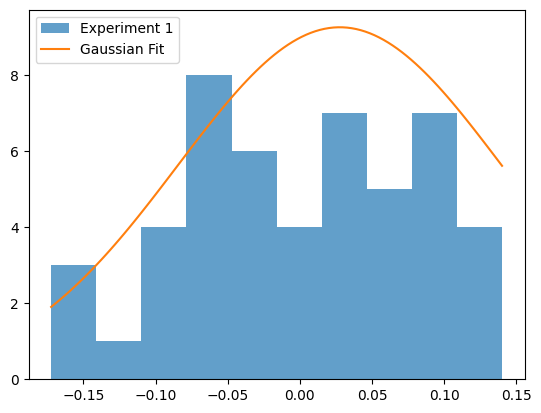

Chi-squared: 25.21, P-value: 0.9961
Fit parameter a: 9.3956 ± 0.0011


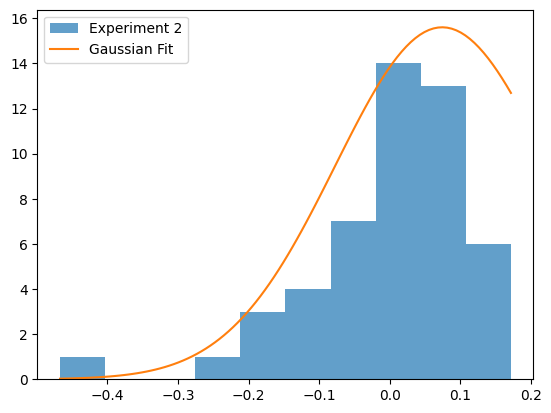

Chi-squared: 28.54, P-value: 0.9847
Fit parameter a: 9.3984 ± 0.0015


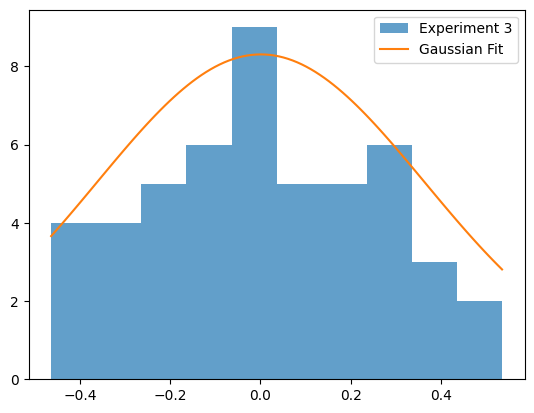

Chi-squared: 23.99, P-value: 0.9979
Fit parameter a: 9.3982 ± 0.0037
Measured g: 9.869 ± 0.0024 m/s^2
Measured g: 9.863 ± 0.0032 m/s^2
Measured g: 9.864 ± 0.0077 m/s^2
Weighted average g: 9.867 ± 0.0019 m/s^2
For the measurements with tape


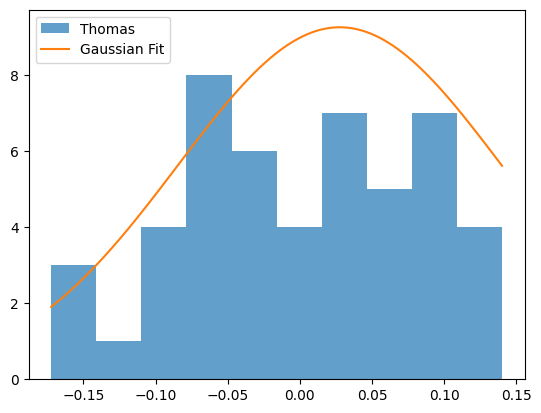

Chi-squared: 25.21, P-value: 0.9961
Fit parameter a: 9.3956 ± 0.0011


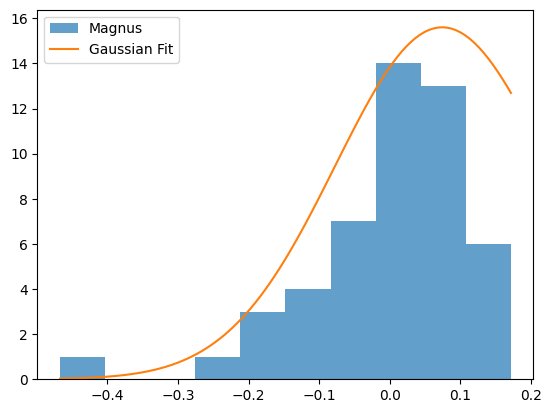

Chi-squared: 28.54, P-value: 0.9847
Fit parameter a: 9.3984 ± 0.0015


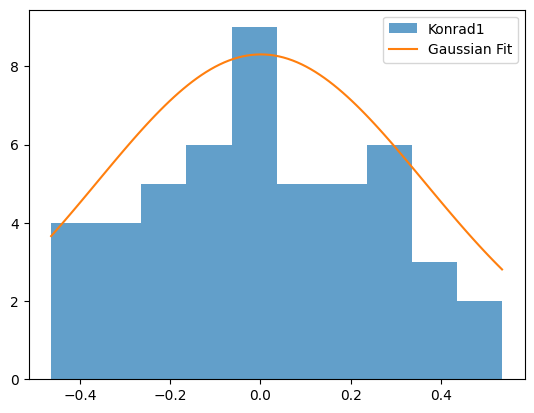

Chi-squared: 23.99, P-value: 0.9979
Fit parameter a: 9.3982 ± 0.0037
Measured g: 9.831 ± 0.0024 m/s^2
Measured g: 9.825 ± 0.0032 m/s^2
Measured g: 9.825 ± 0.0077 m/s^2
Weighted average g: 9.829 ± 0.0019 m/s^2


In [176]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats

# Define errorfunc to calculate and fit the data
def errorfunc(i, labels):
    sy = 1
    time_space = np.arange(0, 49, 1)

    # Initial linear fit
    initial_fit = cost.LeastSquares(time_space, i, sy, linfunc)
    initial_minuit = Minuit(initial_fit, a=2, b=1)
    initial_minuit.migrad()
    a, b = initial_minuit.values['a'], initial_minuit.values['b']
    yfit = linfunc(time_space, a, b)

    # Residual histogram and Gaussian fit
    residuals = i - yfit
    count, bins = np.histogram(residuals, bins=int(np.sqrt(len(i))))
    mask = count > 0
    count = count[mask]
    bin_centers = 0.5 * (bins[1:] + bins[:-1])[mask]
    bin_width = bins[1] - bins[0]

    gauss_fit = cost.LeastSquares(bin_centers, count, np.sqrt(count), gauss_pdf)
    gauss_minuit = Minuit(gauss_fit, mu=0, sigma=20, N=sum(count) * bin_width)
    gauss_minuit.limits["sigma"] = (0, None)
    gauss_minuit.migrad()

    gauss_params = gauss_minuit.values
    sigma = gauss_params['sigma']

    # Refined linear fit with updated uncertainty
    refined_fit = cost.LeastSquares(time_space, i, sigma, linfunc)
    refined_minuit = Minuit(refined_fit, a=a, b=b)
    refined_minuit.migrad()
    yfit = linfunc(time_space, *refined_minuit.values)

    # Chi-squared and p-value calculation
    chi2 = np.sum((i - yfit) ** 2 / sigma ** 2)
    p_val = stats.chi2.sf(chi2, len(i) - 2)

    # Plot results
    extraspace = np.linspace(min(bins), max(bins), 100)
    plt.hist(residuals, label=f'{labels}', alpha=0.7)
    plt.plot(
        extraspace,
        gauss_pdf(extraspace, gauss_params['mu'], gauss_params['sigma'], gauss_params['N']),
        label="Gaussian Fit"
    )
    plt.legend()
    plt.show()

    print(f"Chi-squared: {chi2:.2f}, P-value: {p_val:.4f}")

    # Print final fit results
    a, b = refined_minuit.values['a'], refined_minuit.values['b']
    ae, be = refined_minuit.errors['a'], refined_minuit.errors['b']
    print(f"Fit parameter a: {a:.4f} ± {ae:.4f}")

    return refined_minuit.values, refined_minuit.errors

# Main computation for experiments
def process_experiments(pendulum_values, labels, length_mean, error_total):
    avals, aerrs, gvals, gerrs = [], [], [], []

    for values, label in zip(pendulum_values, labels):
        fit_vals, fit_errs = errorfunc(values, label)
        avals.append(fit_vals['a'])
        aerrs.append(fit_errs['a'])

    for a, ae in zip(avals, aerrs):
        g = g_pendul(length_mean, a)
        g_err = g_error(length_mean, a, error_total, ae)
        print(f"Measured g: {g:.3f} ± {g_err:.4f} m/s^2")
        gvals.append(g)
        gerrs.append(g_err)

    gerrs = np.array(gerrs)
    weighted_avg = np.sum(gvals[:-1] / gerrs[:-1]**2) / np.sum(1 / gerrs[:-1]**2)
    weighted_err = np.sqrt(1 / np.sum(1 / gerrs[:-1]**2))

    print(f"Weighted average g: {weighted_avg:.3f} ± {weighted_err:.4f} m/s^2")
    return gvals, gerrs

# Process laser measurements
print("For the measurements with the laser")
laser_labels = ['Experiment 1', 'Experiment 2', 'Experiment 3']
gvals1, gerrs1 = process_experiments(pendulum_values[:-1], laser_labels, Length_laser_mean, error_pendul_laser)

# Process tape measurements
print("For the measurements with tape")
tape_labels = ['Thomas', 'Magnus', 'Konrad1']
gvals2, gerrs2 = process_experiments(pendulum_values[:-1], tape_labels, massmiddle_tape, error_tape_total)


## Test data

In [6]:
Incline_data = ["test_NormDir.txt",
           "test_RevDir.txt",
        ]
Pendulum_data = ["test_pend1.txt",
           "test_pend2.txt",
        ]
Pendulum_period = np.array([])
time_pend = np.array([])
Inc1 = np.array([])
time_inc = np.array([]) 
for (i,j) in zip(Incline_data,Pendulum_data):
    temp_time,temp_Inc1 = np.loadtxt(i, skiprows=0, unpack=True)
    temper_time2,temp_Pend1 = np.loadtxt(j, skiprows=0, unpack=True)
    Inc1 = np.append(Inc1,temp_Inc1)
    Pendulum_period = np.append(Pendulum_period,temp_Pend1)
    time_inc = np.append(time_inc,temp_time)
    time_pend = np.append(time_pend,temper_time2)
    

In [7]:
Minuit.print_level = 1
sy = 0.1
test = cost.LeastSquares(time_pend,Pendulum_period,sy,linfunc) # Function that fits, sy is error?
mfit = Minuit(test, a=1, b=1)
mfit.migrad()
#plt.hist(Pendulum_period-linfunc(time_pend,*mfit.values))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 41.48 (χ²/ndof = 0.9)      │              Nfcn = 38               │
│ EDM = 1.02e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  7.5132   │  0.0020   │            │            │         │         │       │
│ 1 │ b    │  -0.062   │   0.029   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │ 3.85e-06   -50e-6 │
│ b │   -50e-6  0.00085 │
└───┴───────────────────┘

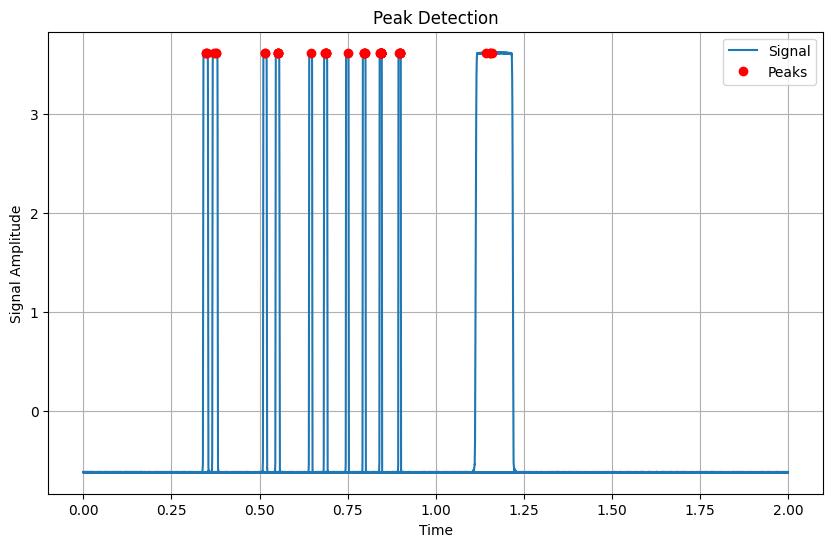

58


In [8]:
# Finding peaks with refined parameters
peaks, properties = find_peaks(
    Inc1, 
    height=3.6201,        # Minimum height
    distance=1,       # Minimum distance between peaks
    prominence=1,    # Prominence of the peaks
    width=0            # Minimum width of peaks
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_inc, Inc1, label="Signal")
plt.plot(time_inc[peaks], Inc1[peaks], "ro", label="Peaks")
plt.xlabel("Time")
plt.ylabel("Signal Amplitude")
plt.title("Peak Detection")
plt.legend()
plt.grid(True)
plt.show()
print(len(Inc1[peaks]))